## Topic Modeling: Latent Dirichlet Allocation with sklearn

### Imports & Settings

In [1]:
using Pkg

In [2]:
#Pkg.add("Glob")
#Pkg.add("WordTokenizers")
#Pkg.add("TextAnalysis")
#Pkg.add("StringEncodings")
#Pkg.add("Plots")
#Pkg.add("StatsPlots")
#Pkg.add("Seaborn")

In [3]:
using PyCall
using Conda

In [4]:
using ScikitLearn

In [5]:
using ScikitLearn: @sk_import

In [6]:
@sk_import feature_extraction.text: CountVectorizer
@sk_import feature_extraction.text: TfidfVectorizer
@sk_import decomposition: LatentDirichletAllocation
@sk_import model_selection: train_test_split

┌ Warning: Module model_selection has been ported to Julia - try `import ScikitLearn: CrossValidation` instead
└ @ ScikitLearn.Skcore C:\Users\Amirreza\.julia\packages\ScikitLearn\Kn82b\src\Skcore.jl:169


PyObject <function train_test_split at 0x00000000792505E0>

In [7]:
using Glob
using DataFrames
using StringEncodings
using Plots
using StatsPlots
using TextAnalysis
using Seaborn

## Load BBC data

Using the BBC data as before, we use [sklearn.decomposition.LatentDirichletAllocation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) to train an LDA model with five topics.

In [8]:
files = Glob.glob("../data/bbc/bbc/**/*.txt")

2225-element Vector{String}:
 "..\\data\\bbc\\bbc\\business\\001.txt"
 "..\\data\\bbc\\bbc\\business\\002.txt"
 "..\\data\\bbc\\bbc\\business\\003.txt"
 "..\\data\\bbc\\bbc\\business\\004.txt"
 "..\\data\\bbc\\bbc\\business\\005.txt"
 "..\\data\\bbc\\bbc\\business\\006.txt"
 "..\\data\\bbc\\bbc\\business\\007.txt"
 "..\\data\\bbc\\bbc\\business\\008.txt"
 "..\\data\\bbc\\bbc\\business\\009.txt"
 "..\\data\\bbc\\bbc\\business\\010.txt"
 "..\\data\\bbc\\bbc\\business\\011.txt"
 "..\\data\\bbc\\bbc\\business\\012.txt"
 "..\\data\\bbc\\bbc\\business\\013.txt"
 ⋮
 "..\\data\\bbc\\bbc\\tech\\390.txt"
 "..\\data\\bbc\\bbc\\tech\\391.txt"
 "..\\data\\bbc\\bbc\\tech\\392.txt"
 "..\\data\\bbc\\bbc\\tech\\393.txt"
 "..\\data\\bbc\\bbc\\tech\\394.txt"
 "..\\data\\bbc\\bbc\\tech\\395.txt"
 "..\\data\\bbc\\bbc\\tech\\396.txt"
 "..\\data\\bbc\\bbc\\tech\\397.txt"
 "..\\data\\bbc\\bbc\\tech\\398.txt"
 "..\\data\\bbc\\bbc\\tech\\399.txt"
 "..\\data\\bbc\\bbc\\tech\\400.txt"
 "..\\data\\bbc\\bbc\\tech\\

In [9]:
doc_list = Any[]
for (i,file) in enumerate(files)
    f = open(file,"r")
    s = StringDecoder(f,"LATIN1", "UTF-8")
    topic = split(file, "\\")[end-1]
    lines = readlines(s)
    heading = strip(lines[1])
    body = strip(join([strip(line) for line in lines[2:end]]))
    push!(doc_list, [uppercasefirst(topic), heading, body])
    close(s)
    close(f)
end

### Convert to DataFrame

In [10]:
docs = DataFrame(topic = [String(x[1]) for x in doc_list], heading = [String(x[2]) for x in doc_list], article = [String(x[3]) for x in doc_list])
first(docs, 5)

,topic,heading,article
,String,String,String
1,Business,Ad sales boost Time Warner profit,"Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-speed broadband. TimeWarner also has to restate 2000 and 2003 results following a probe by the US Securities Exchange Commission (SEC), which is close to concluding.Time Warner's fourth quarter profits were slightly better than analysts' expectations. But its film division saw profits slump 27% to $284m, helped by box-office flops Alexander and Catwoman, a sharp contrast to year-earlier, when the third and final film in the Lord of the Rings trilogy boosted results. For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn. ""Our financial performance was strong, meeting or exceeding all of our full-year objectives and greatly enhancing our flexibility,"" chairman and chief executive Richard Parsons said. For 2005, TimeWarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins.TimeWarner is to restate its accounts as part of efforts to resolve an inquiry into AOL by US market regulators. It has already offered to pay $300m to settle charges, in a deal that is under review by the SEC. The company said it was unable to estimate the amount it needed to set aside for legal reserves, which it previously set at $500m. It intends to adjust the way it accounts for a deal with German music publisher Bertelsmann's purchase of a stake in AOL Europe, which it had reported as advertising revenue. It will now book the sale of its stake in AOL Europe as a loss on the value of that stake."
2,Business,Dollar gains on Greenspan speech,"The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.And Alan Greenspan highlighted the US government's willingness to curb spending and rising household savings as factors which may help to reduce it. In late trading in New York, the dollar reached $1.2871 against the euro, from $1.2974 on Thursday. Market concerns about the deficit has hit the greenback in recent months. On Friday, Federal Reserve chairman Mr Greenspan's speech in London ahead of the meeting of G7 finance ministers sent the dollar higher after it had earlier tumbled on the back of worse-than-expected US jobs data. ""I think the chairman's taking a much more sanguine view on the current account deficit than he's taken for some time,"" said Robert Sinche, head of currency strategy at Bank of America in New York. ""He's taking a longer-term view, laying out a set of conditions under which the current account deficit can improve this year and next.""Worries about the deficit concerns about China do, however, remain. China's currency remains pegged to the dollar and the US currency's sharp falls in recent months have therefore made Chinese export prices highly competitive. But calls for a shift in Beijing's policy have fallen on deaf ears, despite recent comme

## Create Train & Test Sets

In [11]:
#Pkg.add("Pandas")
using Pandas

In [12]:
pd_docs = Pandas.DataFrame(docs)
pd_train_docs, pd_test_docs = train_test_split(pd_docs,
                                         stratify=pd_docs.topic,
                                         test_size=125,
                                         random_state=42)

2-element Vector{PyObject}:
 PyObject               topic  ...                                            article
1457          Sport  ...  Middlesbrough boss Steve McClaren hopes that S...
1971           Tech  ...  A user of Apple's iTunes music service is suin...
1077       Politics  ...  Plans to allow Home Secretary Charles Clarke t...
1662          Sport  ...  David dal Maso has been handed the task of rep...
2099           Tech  ...  Video game giant Electronic Arts (EA) says it ...
...             ...  ...                                                ...
1038       Politics  ...  A call for ethnic minority shortlists to boost...
1777          Sport  ...  Justine Henin-Hardenne lost to Elena Dementiev...
1495          Sport  ...  Chelsea manager Jose Mourinho expects the Cham...
611   Entertainment  ...  Actor Daniel Day-Lewis is to be presented with...
1267       Politics  ...  Ministers will invite international observers ...

[2100 rows x 3 columns]
 PyObject          topic 

In [13]:
train_docs = DataFrames.DataFrame(topic = [topic for topic ∈ pd_train_docs.topic], 
    heading = [heading for heading ∈ pd_train_docs.heading], 
    article = [article for article ∈ pd_train_docs.article])

,topic,heading,article
,String,String,String
1,Sport,Downing injury mars Uefa victory,"Middlesbrough boss Steve McClaren hopes that Stewart Downing did not seriously damage his hamstring during the 2-1 Uefa Cup win over Graz AK.The winger was carried off on a stretcher in the closing stages as Boro booked their place in the last 16. McClaren said: ""Stewart has tweaked a hamstring, which is a blow for us. We will assess it in the morning. ""But I'm delighted with the match result. They say in sport you can win ugly - and we certainly did."" McClaren was relieved to make it through after a tough encounter at The Riverside.""To be fair to Graz, they had a gameplan - they knocked the ball forward, especially in the first half, and we struggled to deal with it. ""In the second half we were better but it was frustrating because we got the goal - but one slip and they were back in it."" Boro face Sporting Lisbon for a place in the quarter-finals after the Portuguese side saw off Feyenoord on Thursday. And McClaren added: ""Sporting are technically very good - Portuguese sides always are. ""But the journey goes on for us and we will now go to their magnificent stadium - after the first game here - we'll look forward to it."" Goalscorer Jimmy Floyd Hasselbaink added: ""It wasn't a particularly beautiful match to watch - but they made it difficult for us. ""We didn't play well at all. But you need a little bit of luck and I think we got that when my shot went through the legs of their goalkeeper. ""I would have liked to play in Holland - that would have been a little bit special to me. ""But so is going back to Portugal - I'll be playing against some lads I played with at Boavista."""
2,Tech,ITunes user sues Apple over iPod,"A user of Apple's iTunes music service is suing the firm saying it is unfair he can only use an iPod to play songs.He says Apple is breaking anti-competition laws in refusing to let other music players work with the site. Apple, which opened its online store in 2003 after launching the iPod in 2001, uses technology to ensure each song bought only plays on the iPod. Californian Thomas Slattery filed the suit in the US District Court in San Jose and is seeking damages.""Apple has turned an open and interactive standard into an artifice that prevents consumers from using the portable hard drive digital music player of their choice,"" the lawsuit states. The key to such a lawsuit would be convincing a court that a single brand like iTunes is a market in itself separate from the rest of the online music market, according to Ernest Gellhorn, an anti-trust law professor at George Mason University. ""As a practical matter, the lower courts have been highly sceptical of such claims,"" Prof Gellhorn said. Apple has sold more than six million iPods since the gadget was launched and has an 87% share of the market for portable digital music players, market research firm NPD Group has reported.More than 200 million songs have been sold by the iTunes music store since it was launched. ""Apple has unlawfully bundled, tied, and/or leveraged its monopoly in the market for the sale of legal online digital music recordings to thwart competition in the separate market for portable hard drive digital music players, and vice-versa,"" the lawsuit said. Mr Slattery called himself an iTunes customer who ""was also forced to purchase an Apple iPod"" if he wanted to take his music with him to listen to. A spokesman for Apple declined to comment. Apple's online music store uses a different format for songs than Napster, Musicmatch, RealPlayer and others. The rivals use the MP3 format or Microsoft's WMA format while Apple uses AAC, which it says helps thwart piracy. The WMA format also includes so-called Digital Rights Management which is used to block piracy."
3,Politics,Anti-terror plan faces first test,"Plans to allow Home Secretary Charles Clarke to place terror suspects under house arrest without trial are set for their first real test in 

In [14]:
test_docs = DataFrames.DataFrame(topic = [topic for topic ∈ pd_test_docs.topic], 
    heading = [heading for heading ∈ pd_test_docs.heading], 
    article = [article for article ∈ pd_test_docs.article])

125×3 DataFrame. Omitted printing of 1 columns
│ Row │ topic         │ heading                               │
│     │ String        │ String                                │
├─────┼───────────────┼───────────────────────────────────────┤
│ 1   │ Politics      │ Kilroy launches 'Veritas' party       │
│ 2   │ Sport         │ Radcliffe eyes hard line on drugs     │
│ 3   │ Business      │ S Korean consumers spending again     │
│ 4   │ Business      │ Quiksilver moves for Rossignol        │
│ 5   │ Tech          │ Britons fed up with net service       │
│ 6   │ Entertainment │ Scissor Sisters triumph at Brits      │
│ 7   │ Politics      │ Tory expert denies defeatism          │
│ 8   │ Sport         │ Melzer shocks Agassi in San Jose      │
│ 9   │ Tech          │ Mobile multimedia slow to catch on    │
│ 10  │ Politics      │ Economy focus for election battle     │
⋮
│ 115 │ Politics      │ Tory candidate quits over remark      │
│ 116 │ Sport         │ Weir poised for Sunderland move       │
│ 117 │ Politics      │ Hague 'given up' his PM ambition      │
│ 118 │ Business      │ Russian oil merger excludes Yukos     │
│ 119 │ Sport         │ Tindall wants second opinion          │
│ 120 │ Business      │ Arsenal 'may seek full share listing' │
│ 121 │ Sport         │ SA return to Mauritius                │
│ 122 │ Politics      │ Child access laws shake-up            │
│ 123 │ Politics      │ Labour MP praises Tory campaign       │
│ 124 │ Business      │ US insurer Marsh cuts 2,500 jobs      │
│ 125 │ Business      │ Yukos bankruptcy 'not US matter'      │

In [15]:
size(train_docs), size(test_docs)

((2100, 3), (125, 3))

In [16]:
value_counts(df, col) = combine(DataFrames.groupby(df, col), nrow)

sort!(value_counts(test_docs, :topic), :nrow, rev=true)

,topic,nrow
,String,Int64
1,Sport,29
2,Business,29
3,Politics,23
4,Tech,22
5,Entertainment,22


### Vectorize train & test sets

In [17]:
# experiments with different settings results yields the following hyperparameters (see issue 50)
vectorizer = TfidfVectorizer(max_df=0.11, min_df=0.026, stop_words="english")

train_dtm = vectorizer.fit_transform(train_docs.article)
words = vectorizer.get_feature_names()
train_dtm

C:\Users\Amirreza\.julia\conda\3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


PyObject <2100x1097 sparse matrix of type '<class 'numpy.float64'>'
	with 113303 stored elements in Compressed Sparse Row format>

In [18]:
test_dtm = vectorizer.transform(test_docs.article)
test_dtm

PyObject <125x1097 sparse matrix of type '<class 'numpy.float64'>'
	with 6777 stored elements in Compressed Sparse Row format>

## LDA with TextAnalysis

In [19]:
?lda

search: lda lda! fieldname fieldnames CrossValidation plot_date LOAD_PATH



```
ϕ, θ = lda(dtm::DocumentTermMatrix, ntopics::Int, iterations::Int, α::Float64, β::Float64; kwargs...)
```

Perform [Latent Dirichlet allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation).

# Required Positional Arguments

  * `α` Dirichlet dist. hyperparameter for topic distribution per document. `α<1` yields a sparse topic mixture for each document. `α>1` yields a more uniform topic mixture for each document.
  * `β` Dirichlet dist. hyperparameter for word distribution per topic. `β<1` yields a sparse word mixture for each topic. `β>1` yields a more uniform word mixture for each topic.

# Optional Keyword Arguments

  * `showprogress::Bool`. Show a progress bar during the Gibbs sampling. Default value: `true`.

# Return Values

  * `ϕ`: `ntopics × nwords` Sparse matrix of probabilities s.t. `sum(ϕ, 1) == 1`
  * `θ`: `ntopics × ndocs` Dense matrix of probabilities s.t. `sum(θ, 1) == 1`


In [20]:
n_components = 5
topic_labels = ["Topic " * string(i) for i ∈ 1:n_components]

5-element Vector{String}:
 "Topic 1"
 "Topic 2"
 "Topic 3"
 "Topic 4"
 "Topic 5"

In [21]:
train_article = [StringDocument(x) for x in train_docs.article]
crps = Corpus(train_article)
update_lexicon!(crps)

In [22]:
m = DocumentTermMatrix(crps)

A 2100 X 46818 DocumentTermMatrix

In [23]:
tf_idf(m)

2100×46818 SparseArrays.SparseMatrixCSC{Float64, Int64} with 468846 stored entries:
⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿

In [24]:
iterations = 10
α = 0.1
β = 0.1
ϕ, θ = lda(m, n_components, iterations, α, β)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


(sparse([1, 2, 3, 4, 5, 1, 2, 3, 4, 5  …  1, 2, 3, 4, 5, 1, 2, 3, 4, 5], [1, 1, 1, 1, 1, 2, 2, 2, 2, 2  …  46817, 46817, 46817, 46817, 46817, 46818, 46818, 46818, 46818, 46818], [5.406895955101136e-5, 1.1235513210154656e-5, 0.0001412660831435659, 0.00037186350838463674, 0.0001862081807460741, 0.011030067748406317, 0.026847258815664552, 0.01779387583276356, 0.022949290803166152, 0.030035943821556135  …  0.0027899583128321863, 0.0009213120832326819, 0.00035033988619604344, 0.0028627587550245845, 0.0006996913458337331, 0.002703447977550568, 0.0008876055436022179, 0.0003785931028247566, 0.0025794341772077184, 0.0010213236580314973], 5, 46818), [0.11676646706586827 0.35170603674540685 … 0.00816326530612245 0.15313653136531366; 0.32934131736526945 0.16272965879265092 … 0.05714285714285714 0.16051660516605165; … ; 0.2964071856287425 0.05511811023622047 … 0.0 0.22693726937269373; 0.15269461077844312 0.30708661417322836 … 0.6163265306122448 0.3413284132841328])

In [25]:
topics_prob = θ
size(topics_prob)

(5, 2100)

In [26]:
topics_prob[1:5, :]

5×2100 Matrix{Float64}:
 0.116766  0.351706   0.0954693  …  0.0        0.00816327  0.153137
 0.329341  0.16273    0.210356      0.498489   0.0571429   0.160517
 0.10479   0.12336    0.0809061     0.253776   0.318367    0.118081
 0.296407  0.0551181  0.2589        0.0725076  0.0         0.226937
 0.152695  0.307087   0.354369      0.175227   0.616327    0.341328

## LDA with sklearn

In [27]:
lda_base = LatentDirichletAllocation(n_components=n_components, learning_method="batch", max_iter=10)
lda_base.fit(train_dtm)

PyObject LatentDirichletAllocation(n_components=5)

## Explore topics & word distributions

In [28]:
topics_count = lda_base.components_
size(topics_count)

(5, 1097)

In [29]:
topics_count[1:5, :]

5×1097 Matrix{Float64}:
 5.57647   5.9792    7.31724   4.95836   …  2.14302   8.34462   6.91521
 0.200359  0.200232  0.384807  0.201921     0.200233  0.200255  0.200232
 0.200285  0.200281  0.200295  0.200302     0.200286  0.200302  0.200293
 6.44424   7.54993   7.69255   3.66708      3.13737   5.31363   1.76377
 2.11815   3.14429   3.91166   3.92249      4.68024   1.84406   7.12922

In [30]:
topics_prob = topics_count ./ sum.(eachrow(topics_count))

5×1097 Matrix{Float64}:
 0.00129041   0.0013836    0.00169323   …  0.00193097   0.0016002
 0.000691721  0.000691282  0.00132851      0.000691361  0.000691282
 0.000874337  0.000874321  0.00087438      0.000874411  0.000874369
 0.001362     0.00159569   0.00162584      0.00112305   0.000372777
 0.000519189  0.000770711  0.000958804     0.000452006  0.00174747

In [31]:
topics = DataFrames.DataFrame()
topics[!, :words] = words
topics = hcat(topics, rename!(DataFrames.DataFrame(transpose(topics_prob)), topic_labels))
first(topics, 5)

,words,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
,String,Float64,Float64,Float64,Float64,Float64
1,100,0.00129041,0.000691721,0.000874337,0.001362,0.000519189
2,11,0.0013836,0.000691282,0.000874321,0.00159569,0.000770711
3,12,0.00169323,0.00132851,0.00087438,0.00162584,0.000958804
4,13,0.00114738,0.000697114,0.000874409,0.000775044,0.000961457
5,14,0.000915452,0.000691357,0.000874369,0.000990765,0.000907597


In [32]:
# all words have positive probability for all topics
topics[:, 2:end] .> 0

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
,Bool,Bool,Bool,Bool,Bool
1,1,1,1,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,1,1,1,1,1
5,1,1,1,1,1
6,1,1,1,1,1
7,1,1,1,1,1
8,1,1,1,1,1
9,1,1,1,1,1


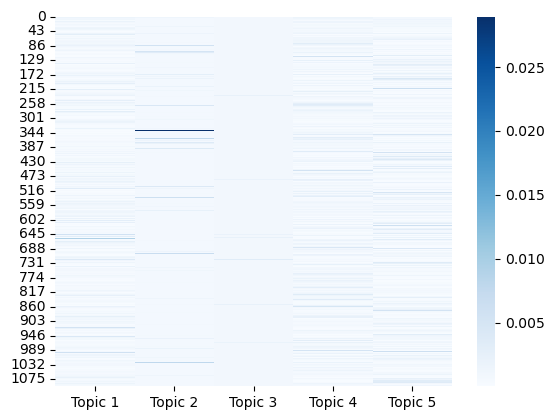

In [33]:
topics_series = [convert(Array, topics[row, :][2:end]) for row ∈ 1:nrow(topics)]
Seaborn.heatmap(topics_series, cmap="Blues", xticklabels=topic_labels);

In [34]:
top_words = Dict()
for i ∈ 1:n_components
    top_words_topic_i = (sort!(DataFrames.select(topics, [1, (i+1)]), topic_labels[i], rev=true))[1:10, :words]
    top_words[topic_labels[i]] = top_words_topic_i
end
top_words_df = DataFrames.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
,String,String,String,String,String
1,film,drugs,commons,economy,labour
2,music,charges,send,growth,club
3,tv,test,devices,bank,team
4,technology,missing,mps,tax,blair
5,mobile,olympic,martin,economic,party
6,software,trial,phone,sales,match
7,users,evidence,using,shares,cup
8,awards,pair,sound,oil,season
9,digital,sport,gives,china,final


C:\Users\Amirreza\.julia\conda\3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


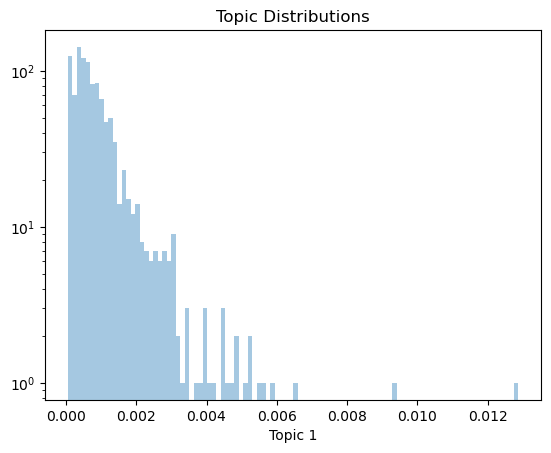

In [35]:
Seaborn.distplot(topics[:, 2],
                bins=100,
                kde=false,
                norm_hist=false).set(yscale="log",
                                    xlabel="Topic " * string(1),
                                    title="Topic Distributions");

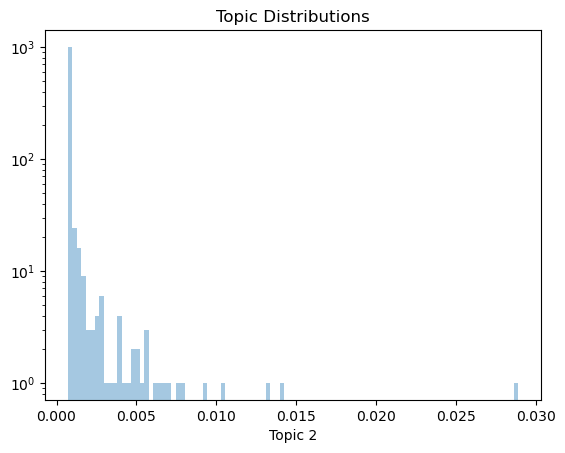

In [36]:
Seaborn.distplot(topics[:, 3],
                bins=100,
                kde=false,
                norm_hist=false).set(yscale="log",
                                    xlabel="Topic " * string(2),
                                    title="Topic Distributions");

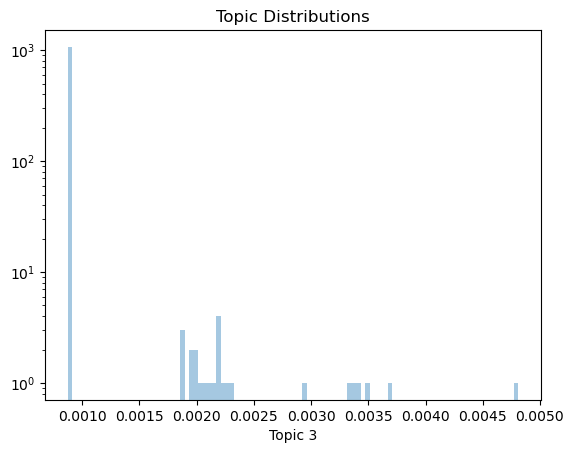

In [37]:
Seaborn.distplot(topics[:, 4],
                bins=100,
                kde=false,
                norm_hist=false).set(yscale="log",
                                    xlabel="Topic " * string(3),
                                    title="Topic Distributions");

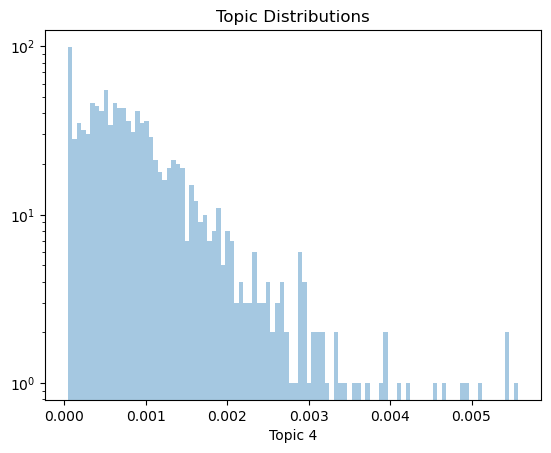

In [38]:
Seaborn.distplot(topics[:, 5],
                bins=100,
                kde=false,
                norm_hist=false).set(yscale="log",
                                    xlabel="Topic " * string(4),
                                    title="Topic Distributions");

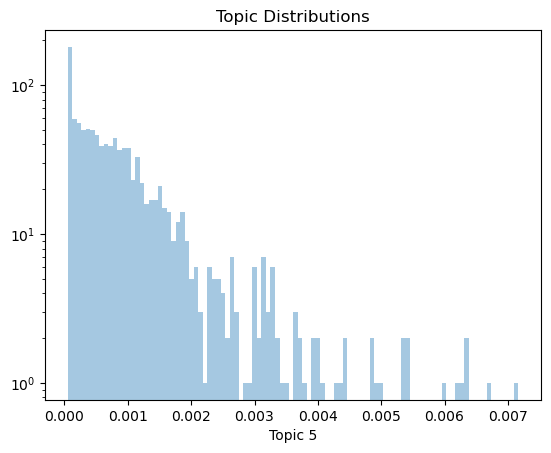

In [39]:
Seaborn.distplot(topics[:, 6],
                bins=100,
                kde=false,
                norm_hist=false).set(yscale="log",
                                    xlabel="Topic " * string(5),
                                    title="Topic Distributions");

## Evaluate Fit on Train Set

In [40]:
train_preds = lda_base.transform(train_dtm)
size(train_preds)

(2100, 5)

In [41]:
train_eval = DataFrame()
train_eval[!, :topic] = train_docs.topic
train_eval = hcat(train_eval, rename!(DataFrame(train_preds), topic_labels))
first(train_eval, 5)

,topic,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
,String,Float64,Float64,Float64,Float64,Float64
1,Sport,0.0297121,0.0293012,0.0292546,0.0297589,0.881973
2,Tech,0.878786,0.0299747,0.0298827,0.0309274,0.0304289
3,Politics,0.0212287,0.0210556,0.0207899,0.915447,0.0214789
4,Sport,0.0410943,0.0406578,0.0405759,0.041154,0.836518
5,Tech,0.880597,0.0293243,0.0292357,0.0304044,0.0304382


In [42]:
mean_topic = by(train_eval, :topic,
                "Topic 1" => mean,
                "Topic 2" => mean,
                "Topic 3" => mean,
                "Topic 4" => mean,
                "Topic 5" => mean)

,topic,Topic 1_mean,Topic 2_mean,Topic 3_mean,Topic 4_mean,Topic 5_mean
,String,Float64,Float64,Float64,Float64,Float64
1,Sport,0.0383158,0.0504287,0.0308589,0.0436715,0.836725
2,Tech,0.808754,0.0287712,0.0282077,0.0954457,0.0388217
3,Politics,0.0427337,0.0277318,0.0317105,0.534954,0.36287
4,Entertainment,0.785479,0.0317126,0.031307,0.0768383,0.0746636
5,Business,0.0589856,0.0294811,0.029062,0.83913,0.0433414


In [43]:
mean_topic = DataFrames.stack(mean_topic, names(mean_topic)[2:6])

,topic,variable,value
,String,Cat…,Float64
1,Sport,Topic 1_mean,0.0383158
2,Tech,Topic 1_mean,0.808754
3,Politics,Topic 1_mean,0.0427337
4,Entertainment,Topic 1_mean,0.785479
5,Business,Topic 1_mean,0.0589856
6,Sport,Topic 2_mean,0.0504287
7,Tech,Topic 2_mean,0.0287712
8,Politics,Topic 2_mean,0.0277318
9,Entertainment,Topic 2_mean,0.0317126


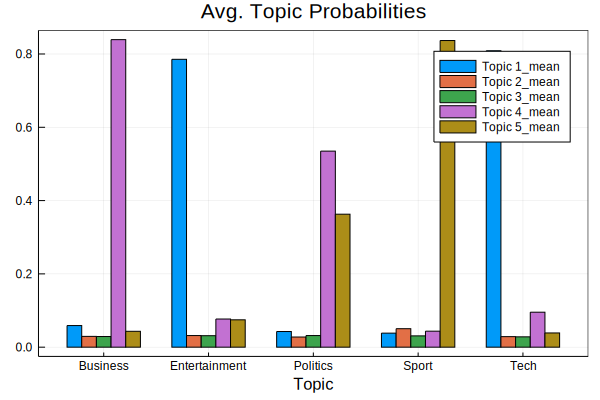

In [44]:
@df mean_topic groupedbar(:topic, :value, group = :variable, xlabel = "Topic",
        title = "Avg. Topic Probabilities", bar_width = 0.7, framestyle = :box)

In [45]:
topic_max = []
for i ∈ 1:nrow(train_eval)
    push!(topic_max, (i, string(findmax(train_eval[i, 2:end])[2])))
end

predicted_test = [topic[2] for topic ∈ topic_max]
predictions = DataFrames.DataFrame(topic = train_eval.topic, predicted = predicted_test)

,topic,predicted
,String,String
1,Sport,Topic 5
2,Tech,Topic 1
3,Politics,Topic 4
4,Sport,Topic 5
5,Tech,Topic 1
6,Politics,Topic 4
7,Entertainment,Topic 1
8,Politics,Topic 4
9,Sport,Topic 5


In [46]:
filter_topic_pred(predictions, topic, predicted) = filter(row -> (row.topic == topic) & (row.predicted == predicted), predictions)

confusion_mtx = DataFrames.DataFrame()
confusion_mtx[!, :topic] = unique(predictions.topic)
for i ∈ 1:5
    topic_i = "Topic " * string(i)
    confusion_mtx[!, topic_i] = [nrow(filter_topic_pred(predictions, topic, topic_i)) for topic ∈ confusion_mtx.topic]
end

confusion_mtx = hcat(confusion_mtx, confusion_mtx[:, 2:end] ./ sum.(eachrow(confusion_mtx[:, 2:end])), makeunique=true)
select!(confusion_mtx, Not(names(confusion_mtx)[2:6]))
rename!(confusion_mtx, append!(["topic"], topic_labels))

,topic,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
,String,Float64,Float64,Float64,Float64,Float64
1,Sport,0.00622407,0.0248963,0.0,0.00207469,0.966805
2,Tech,0.931398,0.0,0.0,0.0633245,0.00527704
3,Politics,0.00761421,0.0,0.00507614,0.601523,0.385787
4,Entertainment,0.934066,0.0,0.0,0.0467033,0.0192308
5,Business,0.02079,0.0,0.0,0.968815,0.010395


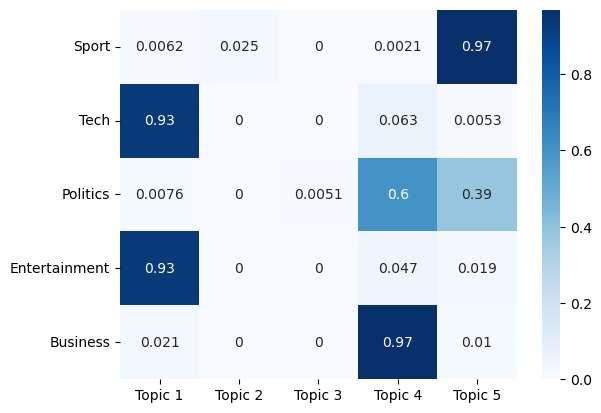

In [47]:
series = [convert(Array, confusion_mtx[row, :])[2:end] for row ∈ 1:nrow(confusion_mtx)]
Seaborn.heatmap(series, annot=true, cmap="Blues", xticklabels=topic_labels, yticklabels=confusion_mtx.topic);

## Evaluate Fit on Test Set 

In [48]:
test_preds = lda_base.transform(test_dtm)
size(test_preds)

(125, 5)

In [49]:
test_eval = DataFrame()
test_eval[!, :topic] = test_docs.topic
test_eval = hcat(test_eval, rename!(DataFrame(test_preds), topic_labels))
first(test_eval, 5)

,topic,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
,String,Float64,Float64,Float64,Float64,Float64
1,Politics,0.0253647,0.0249314,0.0248734,0.0881565,0.836674
2,Sport,0.264045,0.201701,0.035244,0.0362351,0.462775
3,Business,0.0322353,0.0310941,0.0310847,0.836194,0.0693915
4,Business,0.0316389,0.0306376,0.0306394,0.875056,0.0320282
5,Tech,0.594849,0.0295766,0.0295858,0.315704,0.0302851


In [50]:
mean_topic = by(test_eval, :topic,
                "Topic 1" => mean,
                "Topic 2" => mean,
                "Topic 3" => mean,
                "Topic 4" => mean,
                "Topic 5" => mean)

,topic,Topic 1_mean,Topic 2_mean,Topic 3_mean,Topic 4_mean,Topic 5_mean
,String,Float64,Float64,Float64,Float64,Float64
1,Politics,0.0788664,0.0285957,0.0285148,0.454568,0.409455
2,Sport,0.0559538,0.0375738,0.0316687,0.0527505,0.822053
3,Business,0.0447967,0.0276667,0.027451,0.853523,0.0465626
4,Tech,0.843956,0.0287218,0.0284559,0.0686847,0.0301817
5,Entertainment,0.840701,0.0327334,0.0317538,0.0505874,0.0442248


In [51]:
mean_topic = DataFrames.stack(mean_topic, names(mean_topic)[2:6])

,topic,variable,value
,String,Cat…,Float64
1,Politics,Topic 1_mean,0.0788664
2,Sport,Topic 1_mean,0.0559538
3,Business,Topic 1_mean,0.0447967
4,Tech,Topic 1_mean,0.843956
5,Entertainment,Topic 1_mean,0.840701
6,Politics,Topic 2_mean,0.0285957
7,Sport,Topic 2_mean,0.0375738
8,Business,Topic 2_mean,0.0276667
9,Tech,Topic 2_mean,0.0287218


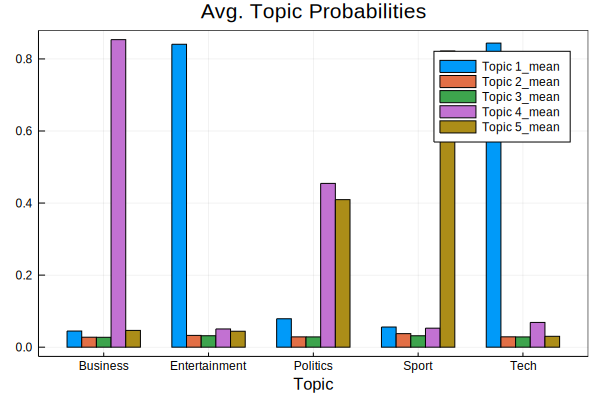

In [52]:
@df mean_topic groupedbar(:topic, :value, group = :variable, xlabel = "Topic",
        title = "Avg. Topic Probabilities", bar_width = 0.7, framestyle = :box)

In [53]:
topic_max = []
for i ∈ 1:nrow(test_eval)
    push!(topic_max, (i, string(findmax(test_eval[i, 2:end])[2])))
end

predicted_test = [topic[2] for topic ∈ topic_max]
predictions = DataFrames.DataFrame(topic = test_eval.topic, predicted = predicted_test)

,topic,predicted
,String,String
1,Politics,Topic 5
2,Sport,Topic 5
3,Business,Topic 4
4,Business,Topic 4
5,Tech,Topic 1
6,Entertainment,Topic 1
7,Politics,Topic 5
8,Sport,Topic 5
9,Tech,Topic 1


In [54]:
filter_topic_pred(predictions, topic, predicted) = filter(row -> (row.topic == topic) & (row.predicted == predicted), predictions)

confusion_mtx = DataFrames.DataFrame()
confusion_mtx[!, :topic] = unique(predictions.topic)
for i ∈ 1:5
    topic_i = "Topic " * string(i)
    confusion_mtx[!, topic_i] = [nrow(filter_topic_pred(predictions, topic, topic_i)) for topic ∈ confusion_mtx.topic]
end

confusion_mtx = hcat(confusion_mtx, confusion_mtx[:, 2:end] ./ sum.(eachrow(confusion_mtx[:, 2:end])), makeunique=true)
select!(confusion_mtx, Not(names(confusion_mtx)[2:6]))
rename!(confusion_mtx, append!(["topic"], topic_labels))

,topic,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
,String,Float64,Float64,Float64,Float64,Float64
1,Politics,0.0869565,0.0,0.0,0.434783,0.478261
2,Sport,0.0344828,0.0,0.0,0.0,0.965517
3,Business,0.0344828,0.0,0.0,0.965517,0.0
4,Tech,1.0,0.0,0.0,0.0,0.0
5,Entertainment,1.0,0.0,0.0,0.0,0.0


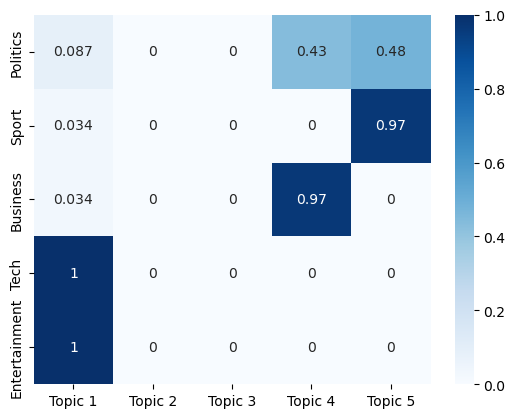

In [55]:
series = [convert(Array, confusion_mtx[row, :])[2:end] for row ∈ 1:nrow(confusion_mtx)]
Seaborn.heatmap(series, annot=true, cmap="Blues", xticklabels=topic_labels, yticklabels=confusion_mtx.topic);

## Retrain until perplexity no longer decreases

In [56]:
lda_opt = LatentDirichletAllocation(n_components=5,
                                    max_iter=500,
                                    learning_method="batch",
                                    evaluate_every=5,
                                    verbose=1,
                                    random_state=42)
lda_opt.fit(train_dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500, perplexity: 2001.0661
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 1903.8257
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500, perplexity: 1889.7029
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 1884.5572
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500, perplexity: 1878.3132
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter:

PyObject LatentDirichletAllocation(evaluate_every=5, max_iter=500, n_components=5,
                          random_state=42, verbose=1)

In [57]:
train_opt_eval = DataFrame()
train_opt_eval[!, :topic] = train_docs.topic
train_opt_eval = hcat(train_opt_eval, rename!(DataFrame(lda_opt.transform(train_dtm)), topic_labels))
first(train_opt_eval, 5)

,topic,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
,String,Float64,Float64,Float64,Float64,Float64
1,Sport,0.0292723,0.881546,0.0296584,0.0296563,0.0298666
2,Tech,0.0298635,0.0302461,0.0525151,0.030296,0.857079
3,Politics,0.0207675,0.0210907,0.0209495,0.0209017,0.916291
4,Sport,0.0405905,0.836266,0.0409694,0.0409749,0.0411997
5,Tech,0.0297798,0.0637875,0.0496485,0.0300236,0.826761


In [58]:
test_opt_eval = DataFrame()
test_opt_eval[!, :topic] = test_docs.topic
test_opt_eval = hcat(test_opt_eval, rename!(DataFrame(lda_opt.transform(test_dtm)), topic_labels))
first(test_opt_eval, 5)

,topic,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
,String,Float64,Float64,Float64,Float64,Float64
1,Politics,0.0249173,0.0255798,0.0251553,0.0250009,0.899347
2,Sport,0.10166,0.400979,0.0384975,0.0356304,0.423232
3,Business,0.0310733,0.077178,0.0318504,0.593404,0.266495
4,Business,0.0306285,0.0318089,0.0316576,0.629329,0.276576
5,Tech,0.0295569,0.0303206,0.0300353,0.119526,0.790561


## Compare Train & Test Topic Assignments 

In [59]:
topic_max = []
for i ∈ 1:nrow(train_opt_eval)
    push!(topic_max, (i, string(findmax(train_opt_eval[i, 2:end])[2])))
end

predicted_test = [topic[2] for topic ∈ topic_max]
predictions = DataFrames.DataFrame(topic = train_opt_eval.topic, predicted = predicted_test)

,topic,predicted
,String,String
1,Sport,Topic 2
2,Tech,Topic 5
3,Politics,Topic 5
4,Sport,Topic 2
5,Tech,Topic 5
6,Politics,Topic 5
7,Entertainment,Topic 5
8,Politics,Topic 5
9,Sport,Topic 2


In [60]:
filter_topic_pred(predictions, topic, predicted) = filter(row -> (row.topic == topic) & (row.predicted == predicted), predictions)

confusion_mtx = DataFrames.DataFrame()
confusion_mtx[!, :topic] = unique(predictions.topic)
for i ∈ 1:5
    topic_i = "Topic " * string(i)
    confusion_mtx[!, topic_i] = [nrow(filter_topic_pred(predictions, topic, topic_i)) for topic ∈ confusion_mtx.topic]
end

confusion_mtx = hcat(confusion_mtx, confusion_mtx[:, 2:end] ./ sum.(eachrow(confusion_mtx[:, 2:end])), makeunique=true)
select!(confusion_mtx, Not(names(confusion_mtx)[2:6]))
rename!(confusion_mtx, append!(["topic"], topic_labels))

,topic,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
,String,Float64,Float64,Float64,Float64,Float64
1,Sport,0.00414938,0.929461,0.00414938,0.00207469,0.060166
2,Tech,0.0,0.00791557,0.0105541,0.0,0.98153
3,Politics,0.0,0.0,0.0,0.0,1.0
4,Entertainment,0.0,0.00824176,0.75,0.00549451,0.236264
5,Business,0.0,0.00831601,0.0,0.559252,0.432432


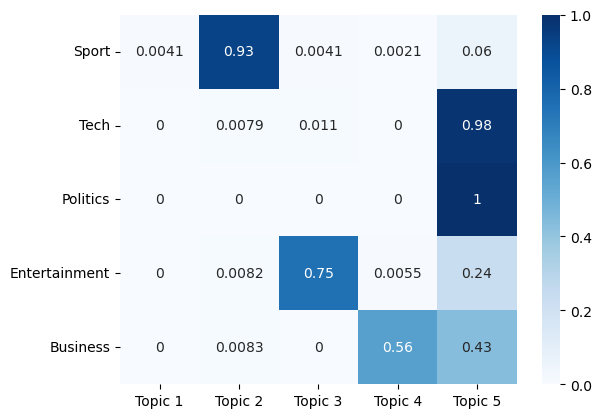

In [61]:
series = [convert(Array, confusion_mtx[row, :])[2:end] for row ∈ 1:nrow(confusion_mtx)]
Seaborn.heatmap(series, annot=true, cmap="Blues", xticklabels=topic_labels, yticklabels=confusion_mtx.topic);

In [62]:
topic_max = []
for i ∈ 1:nrow(test_opt_eval)
    push!(topic_max, (i, string(findmax(test_opt_eval[i, 2:end])[2])))
end

predicted_test = [topic[2] for topic ∈ topic_max]
predictions = DataFrames.DataFrame(topic = test_opt_eval.topic, predicted = predicted_test)

,topic,predicted
,String,String
1,Politics,Topic 5
2,Sport,Topic 5
3,Business,Topic 4
4,Business,Topic 4
5,Tech,Topic 5
6,Entertainment,Topic 3
7,Politics,Topic 5
8,Sport,Topic 2
9,Tech,Topic 5


In [63]:
filter_topic_pred(predictions, topic, predicted) = filter(row -> (row.topic == topic) & (row.predicted == predicted), predictions)

confusion_mtx = DataFrames.DataFrame()
confusion_mtx[!, :topic] = unique(predictions.topic)
for i ∈ 1:5
    topic_i = "Topic " * string(i)
    confusion_mtx[!, topic_i] = [nrow(filter_topic_pred(predictions, topic, topic_i)) for topic ∈ confusion_mtx.topic]
end

confusion_mtx = hcat(confusion_mtx, confusion_mtx[:, 2:end] ./ sum.(eachrow(confusion_mtx[:, 2:end])), makeunique=true)
select!(confusion_mtx, Not(names(confusion_mtx)[2:6]))
rename!(confusion_mtx, append!(["topic"], topic_labels))

,topic,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
,String,Float64,Float64,Float64,Float64,Float64
1,Politics,0.0,0.0,0.0,0.0,1.0
2,Sport,0.0,0.896552,0.0344828,0.0,0.0689655
3,Business,0.0,0.0344828,0.0,0.482759,0.482759
4,Tech,0.0,0.0,0.0,0.0,1.0
5,Entertainment,0.0,0.0,0.909091,0.0,0.0909091


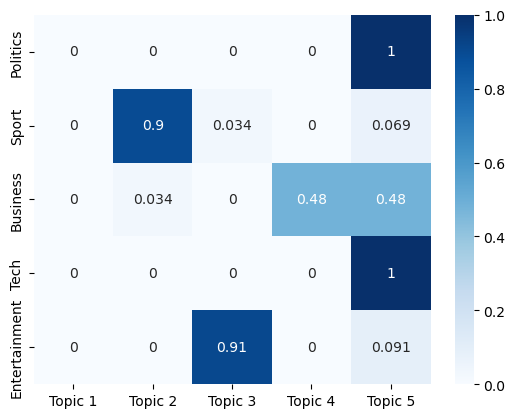

In [64]:
series = [convert(Array, confusion_mtx[row, :])[2:end] for row ∈ 1:nrow(confusion_mtx)]
Seaborn.heatmap(series, annot=true, cmap="Blues", xticklabels=topic_labels, yticklabels=confusion_mtx.topic);

## Explore misclassified articles 

In [65]:
topic_max = []
for i ∈ 1:nrow(test_opt_eval)
    push!(topic_max, (i, string(findmax(test_opt_eval[i, 2:end])[2])))
end

predicted_test = [topic[2] for topic ∈ topic_max]

test_assignments = hcat(test_docs, DataFrames.DataFrame(predicted = predicted_test))
first(test_assignments[[:topic, :heading, :predicted]], 5)

,topic,heading,predicted
,String,String,String
1,Politics,Kilroy launches 'Veritas' party,Topic 5
2,Sport,Radcliffe eyes hard line on drugs,Topic 5
3,Business,S Korean consumers spending again,Topic 4
4,Business,Quiksilver moves for Rossignol,Topic 4
5,Tech,Britons fed up with net service,Topic 5


In [66]:
misclassified = filter(row -> (row.topic .== "Entertainment") & (row.predicted .== "Topic 5"), test_assignments)
misclassified.heading

2-element Vector{String}:
 "Neeson in bid to revive theatre"
 "Campaigners attack MTV 'sleaze'"

In [67]:
misclassified.article

2-element Vector{String}:
 "Hollywood film star Liam Neeso" ⋯ 2009 bytes ⋯ "chance to play him some time.\""
 "MTV has been criticised for \"i" ⋯ 1900 bytes ⋯ "s sexual health and tolerance."

## PyLDAVis

LDAvis helps you interpret LDA results by answer 3 questions:

1. What is the meaning of each topic?
2. How prevalent is each topic?
3. How do topics relate to each other?

Topic visualization facilitates the evaluation of topic quality using human judgment. pyLDAvis is a python port of LDAvis, developed in R and D3.js. We will introduce the key concepts; each LDA implementation notebook contains examples.

pyLDAvis displays the global relationships among topics while also facilitating their semantic evaluation by inspecting the terms most closely associated with each individual topic and, inversely, the topics associated with each term. It also addresses the challenge that terms that are frequent in a corpus tend to dominate the multinomial distribution over words that define a topic. LDAVis introduces the relevance r of term w to topic t to produce a flexible ranking of key terms using a weight parameter 0<=ƛ<=1. 

With $\phi_{wt}$  as the model’s probability estimate of observing the term w for topic t, and   as the marginal probability of w in the corpus:
$$r(w, k | \lambda) = \lambda \log(\phi_{kw}) + (1 − \lambda) \log \frac{\phi_{kw}}{p_w}$$

The first term measures the degree of association of term t with topic w, and the second term measures the lift or saliency, i.e., how much more likely the term is for the topic than in the corpus. 

The tool allows the user to interactively change ƛ to adjust the relevance, which updates the ranking of terms. User studies have found that ƛ=0.6 produces the most plausible results. 

## Refit using all data

In [68]:
vectorizer = CountVectorizer(max_df=.5, 
                             min_df=5,
                             stop_words="english",
                             max_features=2000)
docs_dtm = vectorizer.fit_transform(docs.article)

PyObject <2225x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 194091 stored elements in Compressed Sparse Row format>

In [69]:
lda_all = LatentDirichletAllocation(n_components=5,
                                    max_iter=500,
                                    learning_method="batch",
                                    evaluate_every=10,
                                    random_state=42,
                                    verbose=1)
lda_all.fit(docs_dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 997.0729
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 993.3065
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter: 500
iteration: 30 of max_iter: 500, perplexity: 992.2409
iteration: 31

PyObject LatentDirichletAllocation(evaluate_every=10, max_iter=500, n_components=5,
                          random_state=42, verbose=1)

#### Lambda

- **$\lambda$ = 0**: how probable is a word to appear in a topic - words are ranked on lift P(word | topic) / P(word)
- **$\lambda$ = 1**: how exclusive is a word to a topic -  words are purely ranked on P(word | topic)

The ranking formula is $\lambda * P(\text{word} \vert \text{topic}) + (1 - \lambda) * \text{lift}$

User studies suggest $\lambda = 0.6$ works for most people.

## Topics as WordClouds

In [70]:
topics_prob = lda_all.components_ ./ sum.(eachrow(lda_all.components_))
topics = DataFrames.DataFrame()
topics[!, :words] = vectorizer.get_feature_names()
topics = hcat(topics, rename!(DataFrames.DataFrame(transpose(topics_prob)), topic_labels))
first(topics, 5)

,words,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
,String,Float64,Float64,Float64,Float64,Float64
1,000,0.00275226,0.00504307,0.000143436,0.00293352,0.00294745
2,10,0.001801,0.00270656,0.00192098,0.000949302,0.00296651
3,100,0.00115968,0.00100195,0.000255357,0.000677694,0.000460894
4,100m,3.35511e-6,0.000231448,0.000592879,2.88563e-6,0.000126563
5,11,0.000336189,0.00135312,0.000664472,0.00042768,0.00191812


In [71]:
#Conda.add("wordcloud")

In [72]:
@pyimport wordcloud

In [73]:
w = wordcloud.WordCloud()

PyObject <wordcloud.wordcloud.WordCloud object at 0x0000000002519A60>

In [74]:
topics[2, 2]

0.0018009950044794766

In [75]:
freq_dict_array = []
for i ∈ topic_labels
    freq_dict_i = Dict()
    for j ∈ 1:nrow(topics)
        word, freq = topics[j, :words], topics[j, i]
        freq_dict_i[word] = freq
    end
    push!(freq_dict_array, freq_dict_i)
end
freq_dict_array

5-element Vector{Any}:
 Dict{Any, Any}("action" => 0.000992852782878891, "hugely" => 0.0005201024375378364, "fight" => 0.00024102970099012372, "spent" => 0.00027280574245665674, "regular" => 0.00029731333732105326, "step" => 0.0005730281232999694, "criticised" => 5.014707941642525e-5, "raise" => 0.00016449202037248318, "helping" => 0.000584708304395102, "western" => 0.00018039058475885294…)
 Dict{Any, Any}("action" => 0.0007245668353061238, "hugely" => 3.4863359315623236e-6, "fight" => 0.00018733188036169744, "spent" => 0.0005028349755232453, "regular" => 5.864518771618548e-5, "step" => 0.00033220074719627046, "criticised" => 0.00014370059039479997, "raise" => 0.001021470032087966, "helping" => 0.0002504975322746929, "western" => 0.0004944968419661694…)
 Dict{Any, Any}("action" => 0.0010821802730355456, "hugely" => 6.757746927964168e-5, "fight" => 0.0002477288670345993, "spent" => 0.00037241953970113716, "regular" => 0.00021387861535286513, "step" => 0.0005397176927467806, "criticised"

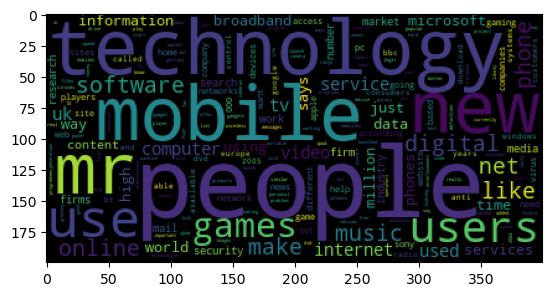

In [76]:
w.generate_from_frequencies(freq_dict_array[1])
imshow(w);

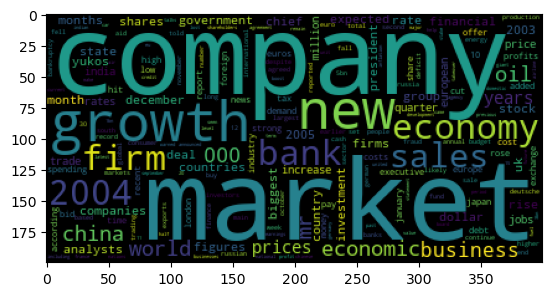

In [77]:
w.generate_from_frequencies(freq_dict_array[2])
imshow(w);

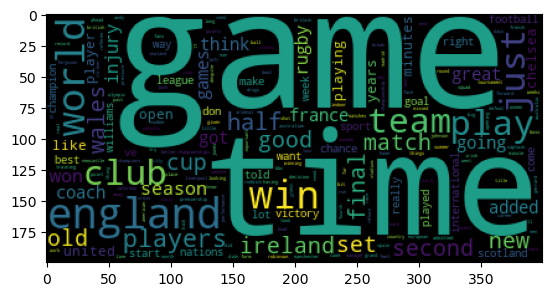

In [78]:
w.generate_from_frequencies(freq_dict_array[3])
imshow(w);

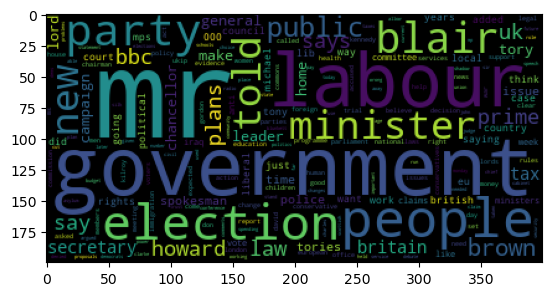

In [79]:
w.generate_from_frequencies(freq_dict_array[4])
imshow(w);

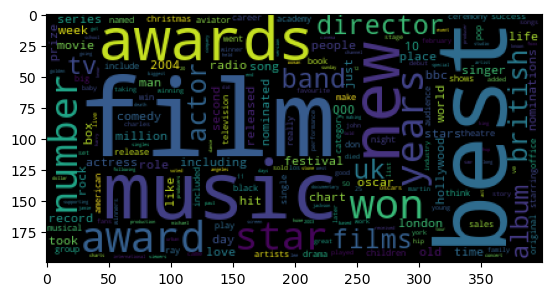

In [80]:
w.generate_from_frequencies(freq_dict_array[5])
imshow(w);

### Visualize topic-word assocations per document

In [81]:
dtm_ = DataFrame()
dtm_[!, :topic] = docs.topic
dtm_ = hcat(dtm_, rename!(DataFrame(lda_all.transform(docs_dtm)), topic_labels))

,topic,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
,String,Float64,Float64,Float64,Float64,Float64
1,Business,0.194983,0.758081,0.00136337,0.00139767,0.0441747
2,Business,0.00135415,0.936009,0.00136086,0.0599196,0.00135602
3,Business,0.00191676,0.932472,0.00192454,0.0469191,0.0167674
4,Business,0.00136823,0.994518,0.00137435,0.00136413,0.00137486
5,Business,0.00272659,0.989023,0.0027673,0.00276568,0.00271789
6,Business,0.201166,0.788456,0.00347636,0.00345394,0.0034475
7,Business,0.00185164,0.938315,0.00187483,0.0561081,0.00185049
8,Business,0.00168161,0.855905,0.00169035,0.139006,0.00171635
9,Business,0.0618754,0.87564,0.00257751,0.0573126,0.00259444


In [82]:
last(dtm_, 5)

,topic,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
,String,Float64,Float64,Float64,Float64,Float64
1,Tech,0.834304,0.161347,0.00147038,0.00144322,0.001436
2,Tech,0.922283,0.0732104,0.00150158,0.00150049,0.00150415
3,Tech,0.504123,0.000697221,0.000692578,0.493797,0.000690087
4,Tech,0.708087,0.00159928,0.00158507,0.287146,0.00158205
5,Tech,0.532352,0.000241663,0.395684,0.0264673,0.0452555


In [83]:
color_dict = Dict()
color_dict["Topic 1"] = Dict(Symbol("color") => "white", Symbol("on_color") => "on_blue")
color_dict["Topic 2"] = Dict(Symbol("color") => "white", Symbol("on_color") => "on_green")
color_dict["Topic 3"] = Dict(Symbol("color") => "white", Symbol("on_color") => "on_red")
color_dict["Topic 4"] = Dict(Symbol("color") => "white", Symbol("on_color") => "on_magenta")
color_dict["Topic 5"] = Dict(Symbol("color") => "blue", Symbol("on_color") => "on_yellow")

Dict{Symbol, String} with 2 entries:
  :color    => "blue"
  :on_color => "on_yellow"

In [84]:
dtm_["article"] = values(docs.article)
dtm_["heading"] = values(docs.heading)
dtm_

,topic,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,article
,String,Float64,Float64,Float64,Float64,Float64,String
1,Business,0.194983,0.758081,0.00136337,0.00139767,0.0441747,"Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-speed broadband. TimeWarner also has to restate 2000 and 2003 results following a probe by the US Securities Exchange Commission (SEC), which is close to concluding.Time Warner's fourth quarter profits were slightly better than analysts' expectations. But its film division saw profits slump 27% to $284m, helped by box-office flops Alexander and Catwoman, a sharp contrast to year-earlier, when the third and final film in the Lord of the Rings trilogy boosted results. For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn. ""Our financial performance was strong, meeting or exceeding all of our full-year objectives and greatly enhancing our flexibility,"" chairman and chief executive Richard Parsons said. For 2005, TimeWarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins.TimeWarner is to restate its accounts as part of efforts to resolve an inquiry into AOL by US market regulators. It has already offered to pay $300m to settle charges, in a deal that is under review by the SEC. The company said it was unable to estimate the amount it needed to set aside for legal reserves, which it previously set at $500m. It intends to adjust the way it accounts for a deal with German music publisher Bertelsmann's purchase of a stake in AOL Europe, which it had reported as advertising revenue. It will now book the sale of its stake in AOL Europe as a loss on the value of that stake."
2,Business,0.00135415,0.936009,0.00136086,0.0599196,0.00135602,"The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.And Alan Greenspan highlighted the US government's willingness to curb spending and rising household savings as factors which may help to reduce it. In late trading in New York, the dollar reached $1.2871 against the euro, from $1.2974 on Thursday. Market concerns about the deficit has hit the greenback in recent months. On Friday, Federal Reserve chairman Mr Greenspan's speech in London ahead of the meeting of G7 finance ministers sent the dollar higher after it had earlier tumbled on the back of worse-than-expected US jobs data. ""I think the chairman's taking a much more sanguine view on the current account deficit than he's taken for some time,"" said Robert Sinche, head of currency strategy at Bank of America in New York. ""He's taking a longer-term view, laying out a set of conditions under which the current account deficit can improve this year and next.""Worries about the deficit concerns about China do, however, remain. China's currency remains pegged to the dollar and the US currency's sharp falls in recent months have therefore made Chinese export prices highly c

In [85]:
sample = filter(row -> (row["Topic 1"] .> 0.05) &
                        (row["Topic 2"] .> 0.05) &
                        (row["Topic 3"] .> 0.05) &
                        (row["Topic 4"] .> 0.05) &
                        (row["Topic 5"] .> 0.05), dtm_)
sample

,topic,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,article
,String,Float64,Float64,Float64,Float64,Float64,String
1,Business,0.0557057,0.606734,0.083133,0.173015,0.081413,"One of Japan's best-known businessmen was arrested on Thursday on charges of falsifying shareholder information and selling shares based on the false data.Yoshiaki Tsutsumi was once ranked as the world's richest man and ran a business spanning hotels, railways, construction and a baseball team. His is the latest in a series of arrests of top executives in Japan over business scandals. He was taken away in a van outside one of his Prince hotels in Tokyo.There was a time when Mr Tsutsumi seemed untouchable. Inheriting a large property business from his father in the 1960s, he became one of Japan's most powerful industrialists, with close connections to many of the country's leading politicians. He used his wealth and influence to bring the Winter Olympic Games to Nagano in 1998. But last year, he was forced to resign from all the posts he held in his business empire, after being accused of falsifying the share-ownership structure of Seibu Railways, one of his companies. Under Japanese stock market rules, no listed company can be more than 80% owned by its 10 largest shareholders. Now Mr Tsutsumi faces criminal charges and the possibility of a prison sentence because he made it look as if the 10 biggest shareholders owned less than this amount. Seibu Railways has been delisted from the stock exchange, its share value has plunged and it is the target of a takeover bid.Mr Tsutsumi's fall from grace follows the arrests of several other top executives in Japan as the authorities try to curb the murky business practices which were once widespread in Japanese companies. His determination to stay at the top at all costs may have had its roots in his childhood. The illegitimate third son of a rich father, who made his money buying up property as Japan rebuilt after World War II, he has described the demands his father made. ""I felt enormous pressure when I dined with him and it was nothing but pain,"" Tsutsumi told a weekly magazine in 1987. ""He scolded me for pouring too much soy sauce or told me fruit was not for children. He didn't let me use the silk futon, saying it's a luxury."" There have been corporate governance issues at some other Japanese companies too. Last year, twelve managers from Mitsubishi Motors were charged with covering up safety defects in their vehicles and three executives from Japan's troubled UFJ bank were charged with concealing the extent of the bank's bad loans."
2,Entertainment,0.152595,0.0714866,0.238235,0.0775495,0.460134,"Broadcaster Chris Evans has begun selling thousands of his possessions from a stall in Camden Market, London.Evans perched on a stool as shoppers wandered around the open-fronted shop packed with his furniture. Among the items from his homes in Los Angeles and London were countless sofas, chairs, pictures, beds and memorabilia from his past TV shows. Asked the reason for the sale, Evans said: ""I just want to get rid of it all, it's just a headache."" He added: ""It feels good to be selling this stuff, it's a weight off my mind. ""Look at it all, there's so much clutter. I've enjoyed every bit of furniture and every poster but it's not important anymore."" The normally gregarious Evans cut a peculiarly unshowbusiness-like figure as he sipped coffee and smoked cigarettes, wrapped in a big coat and scarf in front of his Aladdin's cave.However, the ostentation of some of the items on sale painted a picture of the eccentricity that endeared him to the British public in shows such as Channel 4's gameshow Don't Forget Your Toothbrush. The most striking thing about many of the pieces was their sheer size. Sofas looked like they could seat a small party and a bed seemed big enough for four. The elaborate nature of the pieces, many custom-made, had to be admired, particularly a huge red and gold upholstered ""throne"" and a strip

In [86]:
#Conda.add("termcolor")

In [87]:
@pyimport termcolor

In [88]:
colored_text = []
for word ∈ split(sample[1, 7])
    try
        topic = string(findmax(topics[topics.words .== lowercase(strip(word)), 2:6][1, :])[2])
        push!(colored_text, termcolor.colored(word; color_dict[topic]...))
    catch
        push!(colored_text, word)
    end
end

In [89]:
println(join([termcolor.colored(k; v...) for (k,v) ∈ zip(keys(color_dict), values(color_dict))], " "), "\n")
println(sample[1, 8], "\n")
println(join(colored_text, " "))

Topic 2 Topic 3 Topic 4 Topic 5 Topic 1

Japanese mogul arrested for fraud

One of Japan's best-known businessmen was arrested on Thursday on charges of falsifying shareholder information and selling shares based on the false data.Yoshiaki Tsutsumi was once ranked as the world's richest man and ran a business spanning hotels, railways, construction and a baseball team. His is the latest in a series of arrests of top executives in Japan over business scandals. He was taken away in a van outside one of his Prince hotels in Tokyo.There was a time when Mr Tsutsumi seemed untouchable. Inheriting a large property business from his father in the 1960s, he became one of Japan's most powerful industrialists, with close connections to many of the country's leading politicians. He used his wealth and influence to bring the Winter Olympic Games to Nagano in 1998. But last year, he was forced to resign from all the posts he held in his business empire, after being accused of falsifying the share-ow